In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.io.wavfile import write, read 
from scipy.io import wavfile
import math
from time import sleep
from math import floor
import pyaudio
import wave





In [ ]:
_, __, act = self.plotting_function(definite_yf_array, definite_sound_array, supposed_sound_array, freq0, freq1, xf_for_array, range_index, N, sample_rate)

In [33]:
filename = "recorded.wav"
chunk = 1024
FORMAT = pyaudio.paInt16
channels = 1
sample_rate = 44100
record_seconds = 12
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=channels,
                rate=sample_rate,
                input=True,
                output=True,
                frames_per_buffer=chunk)
frames = []
print("Recording")
for i in range(int(sample_rate / chunk * record_seconds)):
  data = stream.read(chunk)
  frames.append(data)
stream.stop_stream()
stream.close()
p.terminate()
wf = wave.open(filename, "wb")
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(sample_rate)
wf.writeframes(b"".join(frames))
wf.close()

Recording


In [30]:
class modulator:

    def __init__(self):
        self.sample_rate, self.freq0, self.freq1, self.text, self.change_time = 44100, 1000, 2000, "1010", 0.5

    def set_values(self, sample_rate, freq0, freq1, text, change_time):
        self.sample_rate, self.freq0, self.freq1, self.text, self.change_time = sample_rate, freq0, freq1, text, change_time
    
    def set_freq0(self, freq0):
       self.freq0 = freq0
    
    def set_freq1(self, freq1):
       self.freq1 = freq1
    
    def set_sample_rate(self, sample_rate):
       self.sample_rate = sample_rate
    
    def set_text(self, text):
       self.text = text
    
    def set_change_time(self, change_time):
       self.change_time = change_time

    @staticmethod
    def generate_sine_wave(freq, sample_rate, duration):
      x = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)
      frequencies = x * freq
      y = np.sin((2 * np.pi) * frequencies)
      return x, y
    
    def signal_modulation(self): #Сама частотная модуляция. Эта часть будет дорабатываться, пока что тут только две частоты(тупо складываем синусоиды двух частот)
      change_time, text, freq0, freq1, sample_rate = self.change_time, self.text, self.freq0, self.freq1, self.sample_rate
      duration = change_time * len(text)
      num = int(duration / change_time)
      time = np.array([], dtype = np.int16)
      signal = np.array([], dtype = np.int16)
      for i in range(num):
        if text[i] == "0":
            freq = freq0
        if text[i] == "1":
            freq = freq1
        time_diff, data = self.generate_sine_wave(freq, sample_rate, change_time)
        signal = np.concatenate((signal, data), axis = None)
        time = np.concatenate((time, time_diff), axis = None)
      return time, signal
    
class wav_manager:
   
   def __init__(self):
    self.recorded_name = "recorded.wav"
    self.writing_name = "tone_ex"

   def set_recorded_name(self, name):
    self.recorded_name = name

   def set_writing_name(self, name):
    self.writing_name = name

   def get_data_sample_rate(self):
    sample_rate, data = wavfile.read(self.recorded_name)
    duration = len(data) / sample_rate 
    return data, sample_rate
   
   def write_sound(self, sample_rate, data):
      write(self.writing_name, sample_rate, data)
   
class decoder:
   
   def __init__(self):
      self.sample_rate, self.freq0, self.freq1, self.change_time, self.index_range = 44100, 1000, 2000, 0.5, 3
    
   def set_freqses(self, freq0 = 1000, freq1 = 2000):
      self.freq0, self.freq1 = freq0, freq1

   def get_freqs_indexes(self, xf):
     index_freq0, index_freq1 = int(7.5 * len(xf) / 330750 * self.freq0), int(7.5 * len(xf) / 330750 * self.freq1)
     return index_freq0, index_freq1
   
   def set_values(self, data, sample_rate, freq0, freq1, change_time, range_index):
      self.data, self.sample_rate, self.freq0, self.freq1, self.change_time, self.freq0_index_standard, self.freq1_index_standard, self.index_range = data, sample_rate, freq0, freq1, change_time, 7.5 * freq0, 7.5 * freq1, range_index
      self.xf = rfftfreq(len(self.data), 1 / self.sample_rate)

   def fourier_abs(self, data):
    sample_rate = self.sample_rate
    duration = int(len(data) / sample_rate)
    xf = rfftfreq(len(data), 1 / sample_rate)
    yf = rfft(data)
    yf = yf.flatten()
    return np.array([xf, np.abs(yf)])
   
   def get_index_start_end_of_longest_ones(self, lt):
     m = 0
     index = 0
     cnt = 0
     end_index = 0
     length = 0
     for i in range(len(lt)):
       a = bool(lt[i])
       if a:
         cnt += 1
       if not a:
         if cnt > m:
           m = cnt
           index = i - cnt
           end_index = index + cnt -1
           length = end_index - index + 1
         cnt = 0
     if cnt > m:
       index = i + 1 - cnt
     return index, end_index, length
   
   def fourier_for_array(self, data_array, sample_rate):
    _, ans = self.fourier_abs(data_array[0])
    ans = [ans]
    for i in range(1, len(data_array)):
      data_window = data_array[i]
      xf_for_array, yf_window = self.fourier_abs(data_window)
      ans = np.concatenate((ans, [yf_window]), axis = 0)
    return xf_for_array, ans
   
   def abs_diff(self, yf_window, xf, freq0, freq1, range_index):
    absolute_difference = abs(self.freq0_sum(yf_window) - self.freq1_sum(yf_window)) ** 2
    return absolute_difference
   
   def calc_index(self, freq, xf):
     index = int(len(xf) / 22050 * freq)
     return index
   
   def freq_sum(self, yf, xf, freq):
     if math.isclose(freq, self.freq0, abs_tol = 1):
       pass
     elif math.isclose(freq, self.freq1, abs_tol = 1):
       pass
     else:
       raise ValueError("you stupid")
     index_range = self.index_range
     index_freq = self.calc_index(freq, xf)
     s = 0
     for i in range(index_freq - index_range, index_freq + index_range):
       amplitude = yf[i]
       s += abs(amplitude)

     return s
   
   def set_change_time(self, change_time):
     self.change_time = change_time

   
   def fill_in(self, yf_array, xf, freq0, freq1):
     freq0, freq1 = self.freq0, self.freq1
     bool_array = np.zeros(len(yf_array), dtype = bool)
     normalized_yf = self.normalize_data_array(yf_array, xf, freq0, freq1)
     for i in range(len(bool_array)):
       window = normalized_yf[i]
       amplitude_freq0, amplitude_freq1 = self.freq_sum(window, xf, freq0), self.freq_sum(window, xf, freq1)
       print(amplitude_freq0, amplitude_freq1)
       if amplitude_freq0 + amplitude_freq1 > 1:
         
         bool_array[i] = True
     return bool_array
   
   def normalize_data_array(self, yf_array, xf, freq0, freq1):
    normalized_array = yf_array
    medium_amplitude_freq0, medium_amplitude_freq1 = self.calc_medium(yf_array, xf, freq0), self.calc_medium(yf_array, xf, freq1)
    for i in range(len(yf_array)):
      window = yf_array[i]
      normalized_array[i] = self.normalize(window, xf, medium_amplitude_freq0, medium_amplitude_freq1)
    return normalized_array
   
   def decoder_1(self, data):
     freq0, freq1 = self.freq0, self.freq1
     sample_rate, change_time, range_index = self.sample_rate, self.change_time, self.index_range
     duration = int(len(data) / sample_rate)      #whole time
     print(duration)
     N0 = int(duration / change_time)        #number of windows
     data_array = self.secure_split(data, N0)         #array of arrays with sound data
     xf_for_array, yf_array = self.fourier_for_array(data_array, sample_rate)  
     yf_for_array_bool = self.fill_in(yf_array, xf_for_array, freq0, freq1)
     rough_beginning_index, rough_end_index, N = self.get_index_start_end_of_longest_ones(yf_for_array_bool)#index where signal  starts (rough estimation)
     definite_yf_array = yf_array[rough_beginning_index - 1:rough_end_index + 2] #sin waves should be found here
     definite_sound_array, supposed_sound_array, p = self.sound_array_by_index(data, rough_beginning_index, rough_end_index, len(yf_for_array_bool))
     print(len(supposed_sound_array.flatten()) / 44100)
     actual_sound = self.find_sound(N, definite_sound_array, supposed_sound_array)
     
     return  actual_sound, yf_for_array_bool, N, rough_beginning_index, rough_end_index, self.sound_data_by_x(definite_sound_array,act, len(supposed_sound_array))

   def find_max(self, x, sound_data, N, l, definite_sound_data):
    next_x = x
    while len(next_x) > 4:
      x_array = self.secure_split(next_x, 3)
      next_x = np.array([x_array[0], x_array[1]])
      x1, x2, x3, x4 = x_array[0][0], x_array[1][0], x_array[2][0], x_array[2][len(x_array[0]) - 1]
      F1, F2, F3, F4 = self.calc_funcions(sound_data, N, x1, x2, x3, x4, definite_sound_data, l)
      if F2 > F3:
        next_x[0], next_x[1] = x_array[0], x_array[1]
        next_x = next_x.flatten()
      else:
        next_x[0], next_x[1] = x_array[1], x_array[2]
        next_x = next_x.flatten()    
    ans_x = np.max(next_x)
    return ans_x, F2
     
   
   def find_sound(self, N, definite_sound_array, supposed_sound_array):
    target_sound_data, definite_sound_data = supposed_sound_array.flatten(), definite_sound_array.flatten()
    l, l2 = len(target_sound_data), len(definite_sound_data)
    X = np.linspace(0, l2 - l, l2 - l)
    X1, X2 = self.secure_split(X,2)[0], self.secure_split(X,2)[1]
    X1, X2 = X1.astype(int), X2.astype(int)
    ans_x1, F1 = self.find_max(X1, target_sound_data, N, l, definite_sound_data)
    ans_x2, F2 = self.find_max(X2, target_sound_data, N, l, definite_sound_data)
    ans, F = max(ans_x1, ans_x2), max(F1, F2)
    print(ans_x1, ans_x2, F, "alg")
    return self.sound_data_by_x(definite_sound_data, ans, l)

   def sound_data_by_x(self, definite_sound_data, x, l):
     ans_sound_data = definite_sound_data[int(x):int(x + l) - 1]
     return ans_sound_data
   
   def F(self, sound_array, N):
     data_array = self.secure_split(sound_array, N)
     xf, yf_array = self.fourier_for_array(data_array, self.sample_rate)
     func = self.calc_function(yf_array, xf)
     return func


       

   def calc_funcions(self, sound_data, N, x1, x2, x3, x4, definite_sound_data, l):
     sound_data1, sound_data2, sound_data3, sound_data4 = self.sound_data_by_x(definite_sound_data, x1, l), self.sound_data_by_x(definite_sound_data, x2, l), self.sound_data_by_x(definite_sound_data, x3, l), self.sound_data_by_x(definite_sound_data, x4, l)
     F1, F2, F3, F4 = self.F(sound_data1, N), self.F(sound_data2, N), self.F(sound_data3, N), self.F(sound_data4, N)
     return F1, F2, F3, F4

   def sound_array_by_index(self, data, index_left, index_right, change_time):
    points_per_window = self.change_time * self.sample_rate
    print(points_per_window, len(data))
    definite_sound_array = data[int(points_per_window * (index_left - 1)): int(points_per_window * (index_right + 2))]
    supposed_sound_array = data[int(points_per_window * (index_left - 1)): int(points_per_window * (index_right))]
    return definite_sound_array, supposed_sound_array, points_per_window
     

   def secure_split(self, d_array, N):
     if len(d_array) % N !=0:
       d_array = np.concatenate((d_array, np.zeros(N - len(d_array) % N)), axis = None)
     d_array = np.split(d_array, N)
     l = np.shape(d_array)
     if len(l) == 3:
        d_array = np.reshape(d_array, (l[0], l[1]))
     return np.array(d_array)
   

  

   def normalize(self, array, xf, medium_amplitude_freq0, medium_amplitude_freq1):
    freq0_amplitude, freq1_amplitude = 0, 0
    index_freq0, index_freq1 = self.calc_index(self.freq0, xf), self.calc_index(self.freq1, xf)
    for i in range(2 * self.index_range):
      freq0_amplitude += array[index_freq0 - self.index_range + i]
      freq1_amplitude += array[index_freq1 - self.index_range + i]
    array[index_freq0 - self.index_range: index_freq0 + self.index_range + 1] = 0
    array[index_freq1 - self.index_range: index_freq1 + self.index_range + 1] = 0
    array[index_freq0], array[index_freq1]  = freq0_amplitude / medium_amplitude_freq0, freq1_amplitude / medium_amplitude_freq1
    return array

   def calc_medium(self, yf_array, xf, freq):
    medium_amplitude = 0
    sum = 0
    N = len(yf_array)
    for i in range(len(yf_array)):
      window = yf_array[i]
      amplitude = self.freq_sum(window, xf, freq)
      sum += abs(amplitude)
    medium_amplitude = sum / N
    return medium_amplitude
   
   def make_step(self, definite_sound_array):
     step = len(definite_sound_array) * 0.0001
     return int(step)
   
   def apply_step(self, definite_sound_array, supposed_sound_array, N, step, number_of_steps, sample_rate):
     changed_sound_array = definite_sound_array[int(step * number_of_steps + step):int(step * number_of_steps + len(supposed_sound_array) + step)]
     changed_sound_data_array = self.secure_split(changed_sound_array, N)
     xf, changed_yf_array = self.fourier_for_array(changed_sound_data_array, sample_rate)
     return xf, changed_yf_array, changed_sound_array
   
   def plotting_function(self, definite_yf_array, definite_sound_array, supposed_sound_array, freq0, freq1, xf, range_index, N, sample_rate):
     number_of_steps = 0
     y_array = np.array([], dtype = float)
     step = self.make_step(definite_sound_array)
     x_array= np.array([], dtype = float)
     while int(step * number_of_steps) + len(supposed_sound_array) + step < len(definite_sound_array) - 1 - step:
        xf, yf_array, changed_sound_array = self.apply_step(definite_sound_array, supposed_sound_array, N, step, number_of_steps, sample_rate)
        func = self.calc_function(yf_array, xf)
        y_array = np.concatenate((y_array, [func]), axis = None)
        step = self.make_step(definite_sound_array)
        supposed_sound_array = changed_sound_array
        x_array = np.concatenate((x_array, [number_of_steps]), axis = None)
        number_of_steps += 1
     plt.plot(y_array)
     m = np.argmax(y_array)
     print(np.max(y_array), "act")
     return x_array, y_array, step*(x_array[m])
   
   def abs_diff(self, yf_window, xf, freq0, freq1):
    absolute_difference = (self.freq_sum(yf_window, xf, freq0) - self.freq_sum(yf_window, xf, freq1))** 2
    return absolute_difference
   
   def calc_function(self, yf_array, xf):
    freq0, freq1 = self.freq0, self.freq1
    func = 0
    for i in range(len(yf_array)):
      yf_window = yf_array[i]
      func += self.abs_diff(yf_window, xf, freq0, freq1)
    return func





          

11
0.009186871239115362 0.01726562664825428
0.008403880813698451 0.012425271047024719
0.009652445235244118 0.017904076498541987
0.015461252052282394 0.017805408163893713
0.007804140885630981 0.017321450725752894
0.005624198035514397 0.01344782196807437
0.012261035763019089 9.415585838542881
8.051913737859982 1.3595201348510888
4.802348323033373 10.924084751433632
8.969278165487703 0.03760140435671718
0.01039540267628488 0.013907708698771054
0.008973844330836108 0.01278533811333451
0.006300424750810402 0.01709918841825058
0.010816802427093571 0.012104670718321876
0.009108356959120463 0.011569872966962633
0.006619289372610169 0.012299280994328855
0.009188618091847952 0.014578624348876178
0.010927077994718204 0.012457578012777188
0.008863668658206349 0.011884405617883637
0.00817468469763764 0.014937745858138318
0.00932832071827657 0.019411687858240604
0.00936945891699648 0.014002114158253195
22050.0 528384
2.0
8628.0 31296.0 1.3740340546229226e+17 alg
1.9474833557674707e+17 act


(array([False, False, False, False, False, False,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False]),
 4,
 6,
 9)

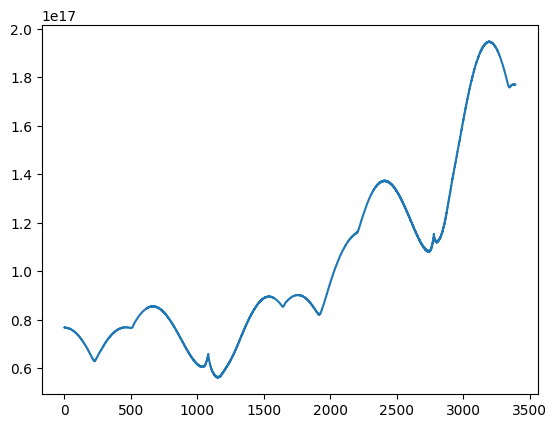

In [34]:
a = decoder()
b = wav_manager()
b.set_recorded_name("recorded.wav")
data, _ = b.get_data_sample_rate()
a.set_freqses(3000, 4000)
a.set_change_time(0.5)
c, d, n, ind1, ind2, s = a.decoder_1(data)
write("ans", 44100, c)
d, n, ind1, ind2

1.9999773242630385


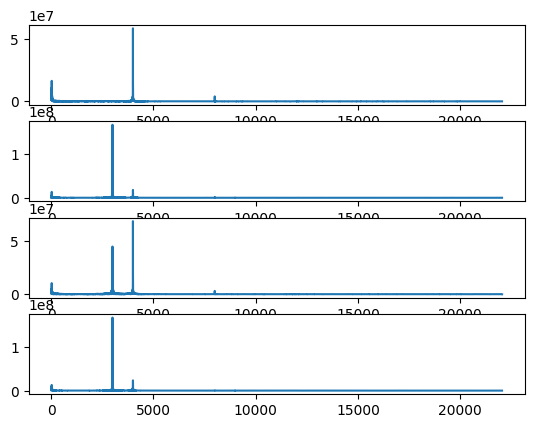

In [35]:
print(len(c)/44100)
figure, axis = plt.subplots(4, 1)
x,y = a.fourier_for_array(a.secure_split(c, 4), 44100)
for i in range(4):
    axis[i].plot(x, y[i])

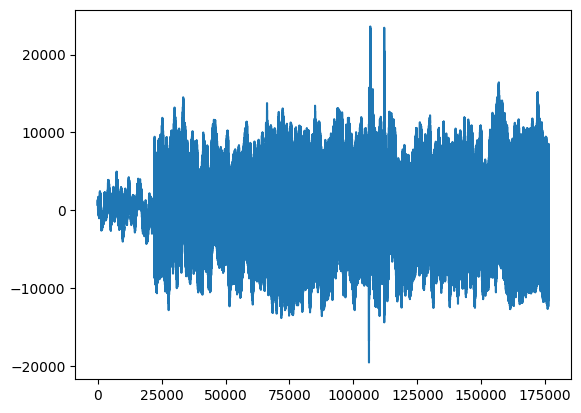

In [9]:
plt.plot(c)

In [304]:
len(c) / 44100

19.99997732426304

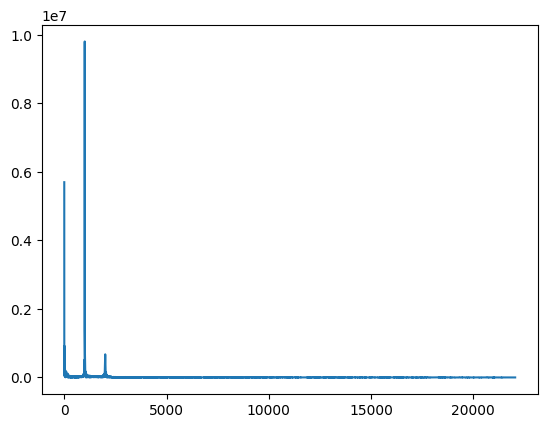

In [307]:
plt.plot(x, y[2])

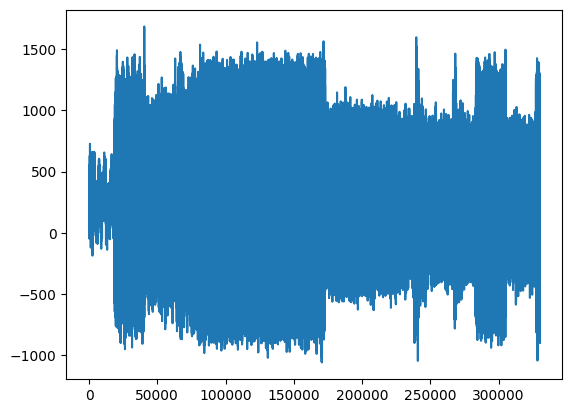

In [50]:
plt.plot(d)

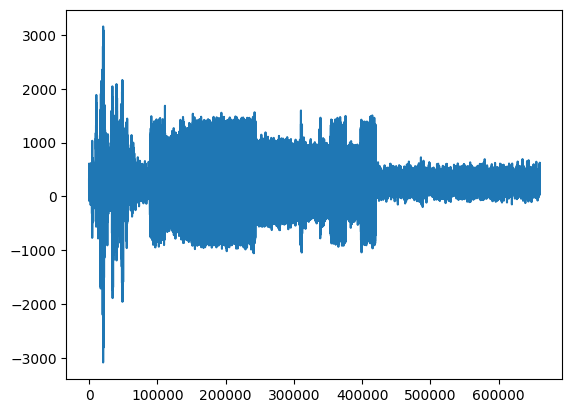

In [41]:
plt.plot(data)

In [ ]:
definite_sound_array = np.reshape(data_array[index_signal_left:index_signal_right+1], (np.shape(data_array[index_signal_left:index_signal_right+1])[0] * np.shape(data_array[index_signal_left:index_signal_right])[1], 1)) #normal form of sound
     supposed_sound_array  = np.reshape(data_array[index_signal_left:index_signal_right], (np.shape(data_array[index_signal_left:index_signal_right])[0] * np.shape(data_array[index_signal_left :index_signal_right])[1], 1)) #normal form of sound

In [121]:
a = np.array([1,2,3,4,5,6,7])
b = np.array([4,5,6])
a[1:3] = 0
a


array([1, 0, 0, 4, 5, 6, 7])

1
2
3
2


In [38]:
a = wav_manager()
a.get_data_sample_rate()

(array([313, 240, 199, ..., 600, 563, 528], dtype=int16), 44100)